# Coffee Data Notebook

Looking at different aspects of the data, mostly to improve collection and have more awareness.


In [1]:
import os
import math

from collections import defaultdict
from tempfile import NamedTemporaryFile

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from optpresso import __file__ as optpresso_path
from optpresso.data.partition import find_test_paths

from astropy import stats as asp
from astropy.utils import NumpyRNGContext
from scipy.stats import median_abs_deviation

from IPython.core.display import display

In [2]:
# Modifiy this to point at the directory where all of the images live.
DATA_DIR = os.path.expanduser("/mnt/nvme/coffee-images/")
OPTPRESSO_DIR = os.path.dirname(optpresso_path)
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv"
plt.rcParams["figure.dpi"] = 150

images_by_time = defaultdict(list)
for time, img_path in find_test_paths(DATA_DIR):
    images_by_time[time].append(img_path)

In [3]:
# Download CSV, won't work on windozes
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
# Clean up the CSV file.
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '')
df = df[df["grinder"].astype(bool)][df["grindersetting"].astype(bool)]
# Only care about data that has a grinder associated
invalid_indices = df[(df["grinder"] == "None") | (df["details"].str.contains("prediction|filter"))].index

df.drop(invalid_indices, inplace=True)
date = pd.to_datetime(df.date, infer_datetime_format=True, utc=True)
roastdate = pd.to_datetime(df.roastdate, infer_datetime_format=True, utc=True)
df = df.assign(days_off_roast = date - roastdate)
df["roastdate"] = df["roastdate"].astype(str).replace("nan", "")

## Coffee Summary

Some quick information about the coffee that has been used. All fun, all subjective.

/home/badisa/miniconda3/envs/optpresso/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


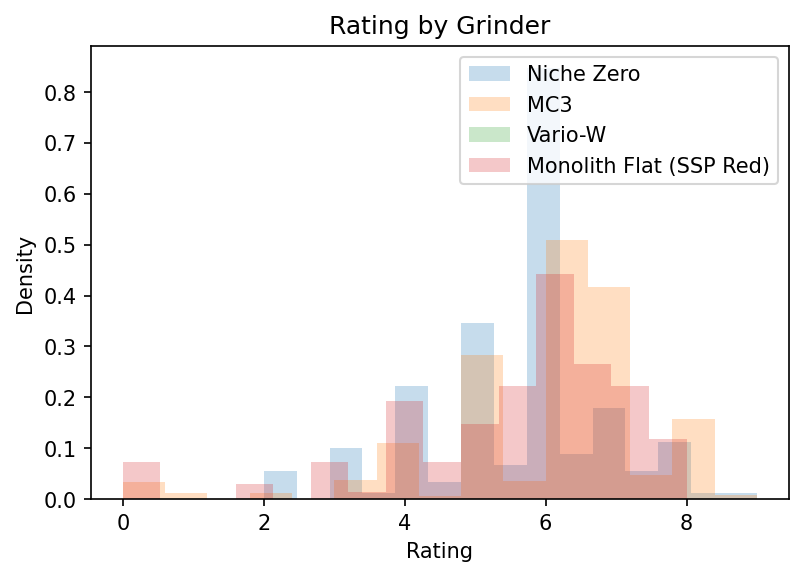

In [4]:
for grinder in df.grinder.unique():
    subdf = df[(df.grinder == grinder) & (df.details.str.contains("spro"))]
    plt.hist(subdf["arbitraryrating1-10"].values, bins=15, density=True, alpha=0.25, label=grinder)
plt.legend()
plt.xlabel("Rating")
plt.ylabel("Density")
plt.title("Rating by Grinder")
plt.show()

In [5]:
groupby = ["coffee"]
coffee_summary = {}
for name, subdf in df.groupby(groupby):
    subdf = subdf[(~subdf["arbitraryrating1-10"].isna()) & (subdf["arbitraryrating1-10"] != 0)]
    if len(subdf) == 0:
        continue
    with NumpyRNGContext(814):
        bootres = asp.bootstrap(subdf["arbitraryrating1-10"].values, len(subdf)*10, bootfunc=np.median)
    coffee_summary[name] = {
        "median": subdf["arbitraryrating1-10"].median(),
        "median_std": bootres.std(),
        "mean": subdf["arbitraryrating1-10"].mean(),
        "std": subdf["arbitraryrating1-10"].std(),
        "count": len(subdf),
    }
flattened_scores = []
for key in coffee_summary.keys():
    if coffee_summary[key]["mean"] in (0.0, float("nan"), np.nan):
        continue
    if coffee_summary[key]["count"] <= 2:
        continue
    flattened_scores.append(
        (
            key,
            coffee_summary[key]["mean"],
            coffee_summary[key]["std"],
            coffee_summary[key]["median"],
            coffee_summary[key]["median_std"],
            coffee_summary[key]["count"],
        )
    )
highest_mean = list(sorted(flattened_scores, reverse=True, key=lambda x: x[1]))[:5]
print("Best Coffees by Mean Rating")
print("="*28)
print()
for name, mean, std, _, _, count in highest_mean:
    print(name)
    print("-"*len(name))
    print(f"Count: {count}, Mean Rating: {mean:.2f}, Std: {std:.2f}")
    print()
highest_median = list(sorted(flattened_scores, reverse=True, key=lambda x: x[3]))[:5]
print("Best Coffees by Median Rating")
print("="*28)
print()
for name, _, _, median, std, count in highest_median:
    print(name)
    print("-"*len(name))
    print(f"Count: {count}, Median Rating: {median}, Std: {std:.2f}")
    print()
lowest_std = list(sorted(flattened_scores, key=lambda x: x[2] if x[2] != 0 else 1000))[:5]
print("Coffees with lowest standard deviation in rating")
print("="*48)
print()
for name, mean, std, median, median_std, count in lowest_std:
    print(name)
    print("-"*len(name))
    print(f"Count: {count}, Mean: {mean:.2f}, Std: {std:.2f}, Median: {median}, Median STD: {median_std:.2f}")
    print()

Best Coffees by Mean Rating

Corvus - Manzana
----------------
Count: 5, Mean Rating: 7.80, Std: 0.84

pmc - kenya mchana estate honey
-------------------------------
Count: 5, Mean Rating: 7.80, Std: 1.10

Mostra Coffee - Columbia Eduin Hernandez
----------------------------------------
Count: 17, Mean Rating: 7.59, Std: 0.84

PMC - Columbia Los Tres Mosqueteros COE 1
-----------------------------------------
Count: 10, Mean Rating: 7.47, Std: 0.83

Candlestick - Corrales Blend
----------------------------
Count: 7, Mean Rating: 7.43, Std: 0.79

Best Coffees by Median Rating

Candlestick - Corrales Blend
----------------------------
Count: 7, Median Rating: 8.0, Std: 0.49

Corvus - Manzana
----------------
Count: 5, Median Rating: 8.0, Std: 0.62

Onyx - El Slvador Santa Rosa Honey
----------------------------------
Count: 11, Median Rating: 8.0, Std: 0.48

PMC - Elida Green Tip Geisha ASD
--------------------------------
Count: 5, Median Rating: 8.0, Std: 0.82

pmc - kenya mchana esta

### Data Distribution

The following graph presents the number of images associated with each pull time. Useful to determine where more data needs to be collected.

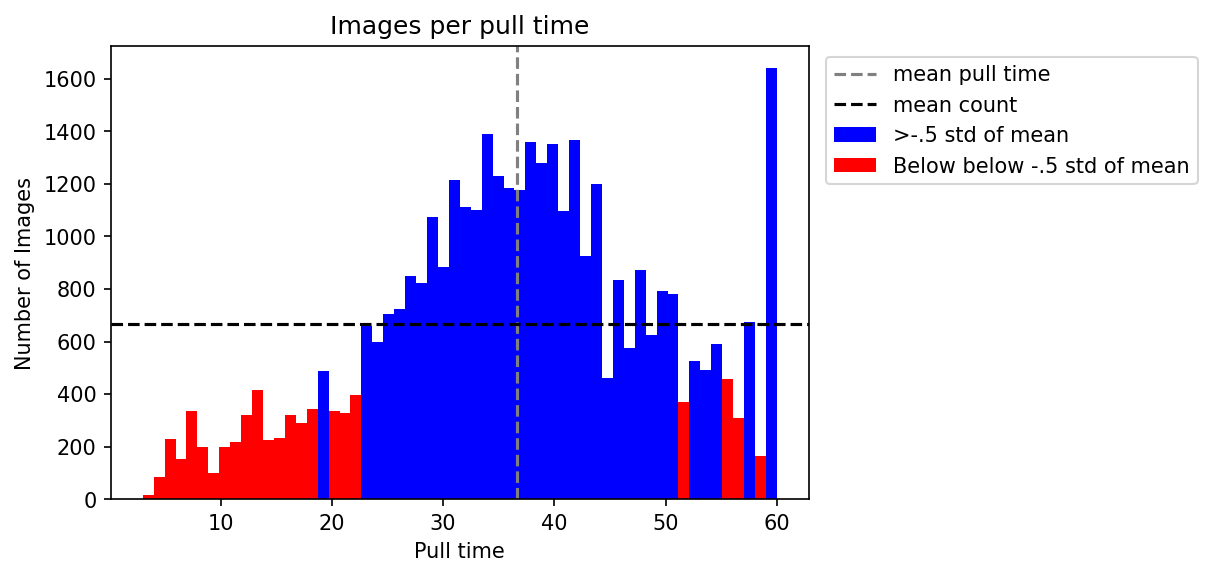

23 pull times which could do with more data
----------
3
4
9
6
59
10
8
11
14
5
15
17
57
16
12
21
20
7
18
52
22
13
56


In [6]:
counts = []
for key, val in images_by_time.items():
    counts.append((key, len(val)))
mean_count = np.mean([x[1] for x in counts])
std_count = np.std([x[1] for x in counts])
counts.sort(key=lambda x: x[1])
lowest = [x[0] for x in counts if x[1] < mean_count - std_count * .5]
good_hist_data = []
low_hist_data = []
for key, val in images_by_time.items():
    if key in lowest:
        for _ in range(len(val)):
            low_hist_data.append(key)
    else:
        for _ in range(len(val)):
            good_hist_data.append(key)
plt.hist(
    [good_hist_data, low_hist_data],
    len(images_by_time),
    color=["blue", "red"],
    stacked=True,
    label=[">-.5 std of mean", "Below below -.5 std of mean"]
)
plt.xlabel("Pull time")
plt.ylabel("Number of Images")
plt.title(f"Images per pull time")
plt.axvline(np.mean(good_hist_data + low_hist_data), label="mean pull time", linestyle="--", color="gray")
plt.axhline(mean_count, label="mean count", linestyle="--", color="black")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()
print(len(lowest), "pull times which could do with more data")
print("----------")
for low in lowest:
    print(low)

### Grinder/Pull Variation

The following looks at the variation seen in shot pull times at the same grind setting. Assumes a normal distribution of the shot times, which has yet to be confirmed.

Only evaluate in cases where there are greater than 2 shots, per bag using roast date as a proxy for batch.

Fit func  
0.03542 x + 0.4295


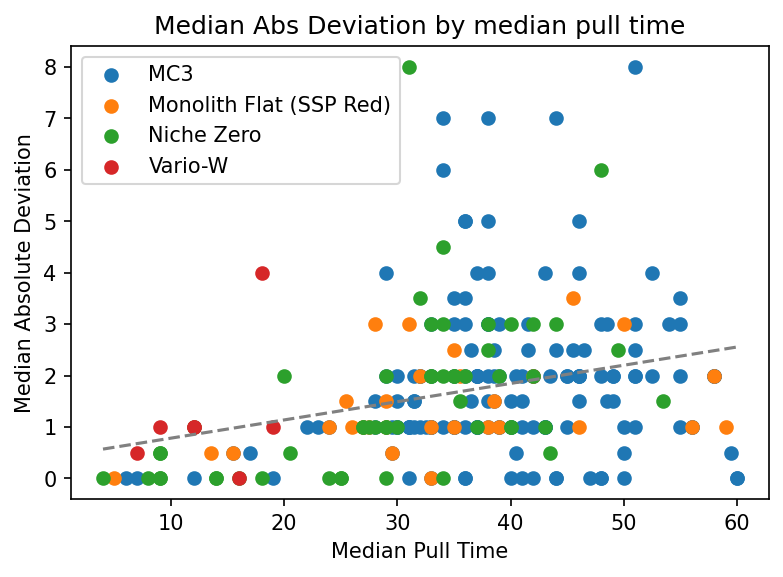

Fit func  
0.0364 x + 0.388


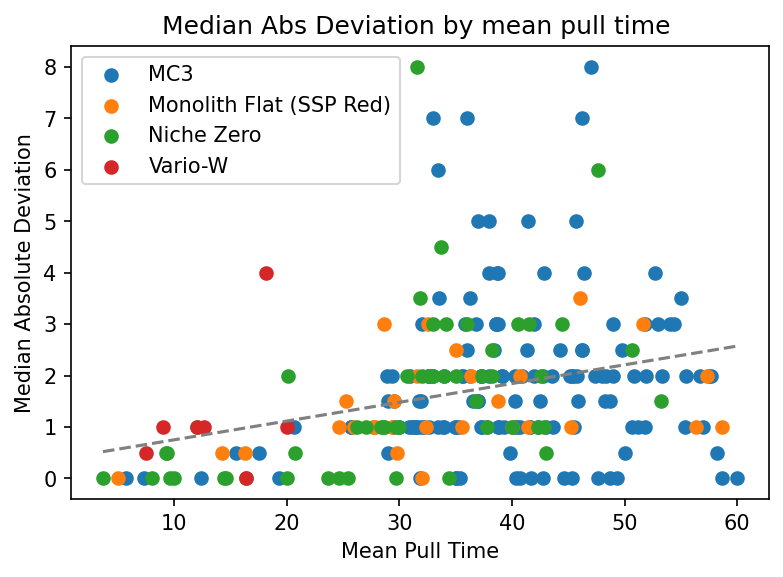

In [7]:
groupby = ["grinder", "grindersetting", "coffee", "roastdate"]
grouped = df.groupby(groupby, dropna=False)

def filter_func(x):
    # Filter out things that don't have a roast date and more than 20 shots or less than 3
    if len(x) < 3:
        return False
    roastdate = x.roastdate.unique()
    if len(roastdate) == 1 and roastdate[0] == "":
        if len(x) < 20:
            return True
        return False
    return True

grouped = grouped.filter(filter_func).groupby(groupby, dropna=False)
x = defaultdict(list)
y = defaultdict(list)
for name, subdf in grouped:
    grinder = subdf.grinder.values[0]
    x[grinder].append(np.median(subdf.time.values))
    y[grinder].append(median_abs_deviation(subdf.time.values))
all_x = []
all_y = []
for grinder in x.keys():
    all_x.extend(x[grinder])
    all_y.extend(y[grinder])
    plt.scatter(x[grinder], y[grinder], label=grinder)
poly_fit = np.poly1d(np.polyfit(all_x, all_y, 1))
print("Fit func", poly_fit)
plt.plot(
    np.unique(all_x),
    poly_fit(np.unique(all_x)),
    color="gray",
    linestyle="--",
)
plt.xlabel("Median Pull Time")
plt.ylabel("Median Absolute Deviation")
plt.title("Median Abs Deviation by median pull time")
plt.legend()
plt.show()

x = defaultdict(list)
for name, subdf in grouped:
    grinder = subdf.grinder.values[0]
    x[grinder].append(np.mean(subdf.time.values))
all_x = []
all_y = []
for grinder in x.keys():
    all_x.extend(x[grinder])
    all_y.extend(y[grinder])
    plt.scatter(x[grinder], y[grinder], label=grinder)
poly_fit = np.poly1d(np.polyfit(all_x, all_y, 1))
print("Fit func", poly_fit)
plt.plot(
    np.unique(all_x),
    poly_fit(np.unique(all_x)),
    color="gray",
    linestyle="--",
)
plt.xlabel("Mean Pull Time")
plt.ylabel("Median Absolute Deviation")
plt.title("Median Abs Deviation by mean pull time ")
plt.legend()
plt.show()

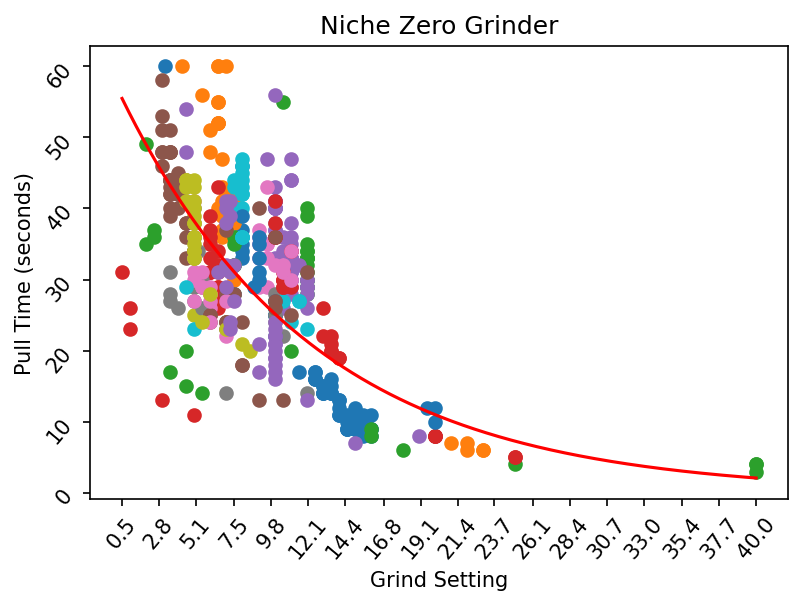

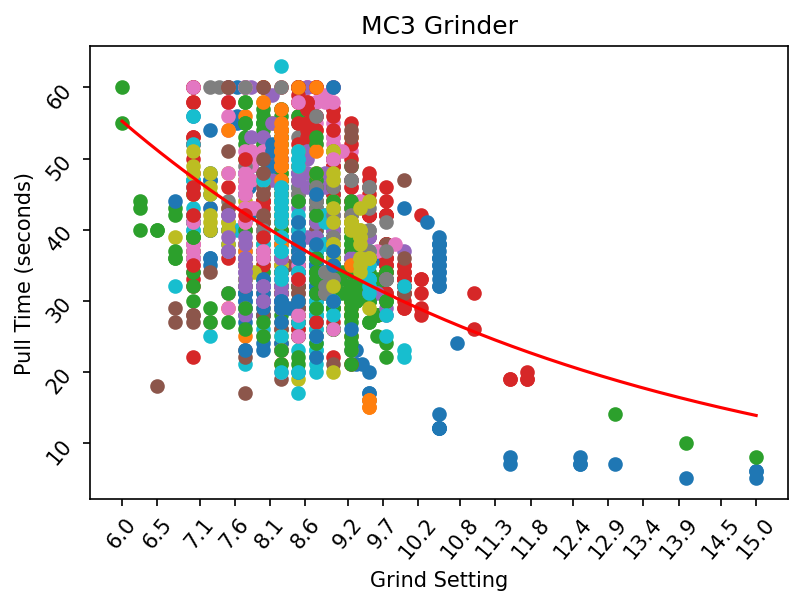

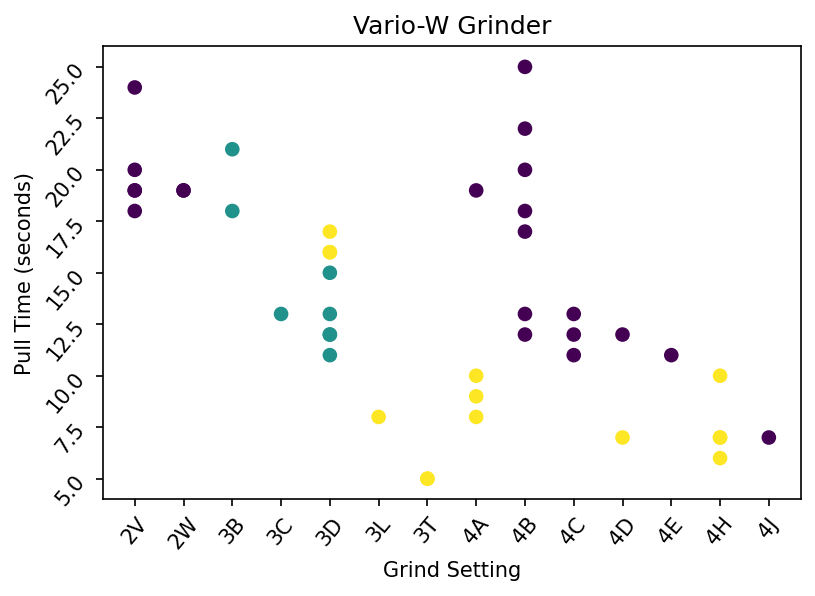

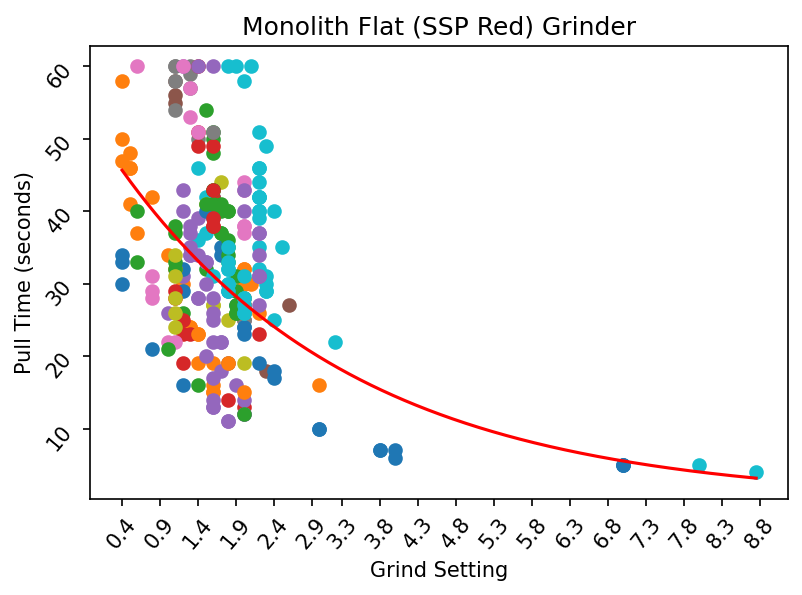

In [8]:
for grinder in df.grinder.unique():
    if grinder == "None":
        continue
    fig = plt.Figure()
    axe = fig.gca()
    subdf = df[(df["grinder"] == grinder)].copy()
    # Sort the list initially
    from scipy.stats import theilslopes, linregress
    try:
        subdf.loc[:, ("grindersetting",)] = pd.to_numeric(subdf.grindersetting)
        subdf = subdf.sort_values("grindersetting", ascending=False)
        slopes = linregress(subdf.grindersetting.values, np.log(subdf.time.values))
        for name, coffeedf in subdf.groupby(["coffee", "roastdate"]):
            axe.scatter(coffeedf.grindersetting, coffeedf.time, label=name)
        even_spacing = np.linspace(subdf.grindersetting.values.min(), subdf.grindersetting.values.max(), 1000)
        axe.plot(even_spacing , np.exp(slopes[1] + slopes[0] * even_spacing), 'r-')
        min_setting = subdf.grindersetting.min()
        max_setting = subdf.grindersetting.max()
        spacing = np.linspace(min_setting, max_setting, int((max_setting - min_setting) // 0.5))
        
        interped_ticks = np.interp(np.linspace(min_setting, max_setting, 18), spacing, spacing)
        axe.set_xticks(np.round(interped_ticks, 1))
    except Exception as e:
        # To get meaningful ordering on the y axis, have to scatter in one pass.
        # Could also move to using numeric y axis values and replacing the labels with
        # the corresponding labels.
        subdf = subdf.sort_values("grindersetting", ascending=True)
        colors = np.zeros_like(subdf.grindersetting.values)
        for i, coffee in enumerate(subdf.coffee.unique()):
            colors[np.argwhere(subdf.coffee.values == coffee)] = i +1
        axe.scatter(subdf.grindersetting, subdf.time, c=colors)
#     axe.plot(subdf.grindersetting.unique(), np.polyfit(subdf.grindersetting, subdf.time, 1)(subdf.grindersetting.unique()))
    axe.set_title(f"{grinder} Grinder")
    axe.set_xlabel("Grind Setting")
    axe.set_ylabel("Pull Time (seconds)")
    axe.tick_params(labelrotation=50)
    
#     axe.set_yscale('log')
    display(fig)